# Classify Electrocardiograms

<img src='https://upload.wikimedia.org/wikipedia/commons/9/9e/SinusRhythmLabels.svg' width=500>


# Data
The data corresponds to electrocardiograms (ECG), which are basically heart beats. Each sequence is therefore a sequence of amplitudes. These ECG are often used to observe heart malfunctions! In this dataset, there are 87554 heart beats and each corresponds to a heart beat type, from 0 to 4:

0 : Normal beat

1 : Supraventricular

2 : Ventricular

3 : Fusion

4 : Beats that cannot be classified

In [1]:
! wget "http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip"
! unzip ECG_data.zip
! rm ECG_data.zip

--2022-03-28 10:12:17--  http://storage.googleapis.com/data-sciences-bootcamp/ECG_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30932601 (29M) [application/zip]
Saving to: ‘ECG_data.zip.1’

ECG_data.zip.1      100%[===================>]  29.50M  --.-KB/s    in 0.1s    

2022-03-28 10:12:18 (212 MB/s) - ‘ECG_data.zip.1’ saved [30932601/30932601]

Archive:  ECG_data.zip
replace ECG_data/X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ECG_data/X.npy          
replace __MACOSX/ECG_data/._X.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/ECG_data/._X.npy  
replace ECG_data/y.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ECG_data/y.npy          
replace __MACOSX/ECG_data/._y.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  infl

In [3]:
#loading environment 
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import set_config

set_config(display='diagram')
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix
''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image

from os import listdir
from os.path import isdir, join
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load data 
X = np.load('ECG_data/X.npy', allow_pickle=True).tolist()
y = np.load('ECG_data/y.npy', allow_pickle=True).tolist()
print(len(X), " time series") 

87554  time series


In [5]:
# visualizing data 
from matplotlib.cm import get_cmap
name = 'tab20c'
cmap = get_cmap(name)
colors_list = cmap.colors

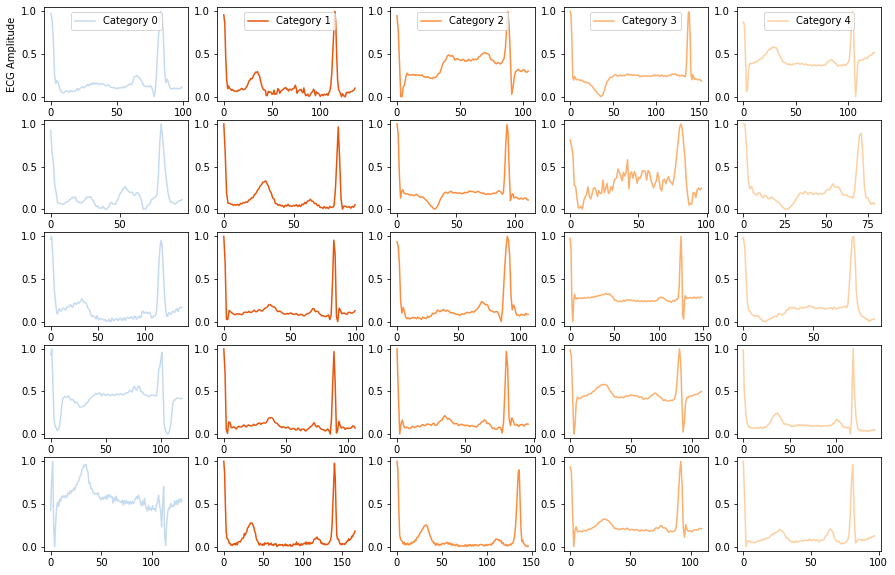

In [6]:
fix, axs = plt.subplots(5, 5, figsize=(15,10))
for i in range(5):
    for j in range(5):
        idx_C = np.argwhere(np.array(y) == j)
        axs[i,j].plot(X[idx_C[i][0]], label=f'Category {j}', c=colors_list[j+3])
        if i == 0:
            axs[i,j].legend(loc='upper center')
            if j ==0:
                axs[i,j].set_xlabel('Time')
                axs[i,j].set_ylabel('ECG Amplitude')

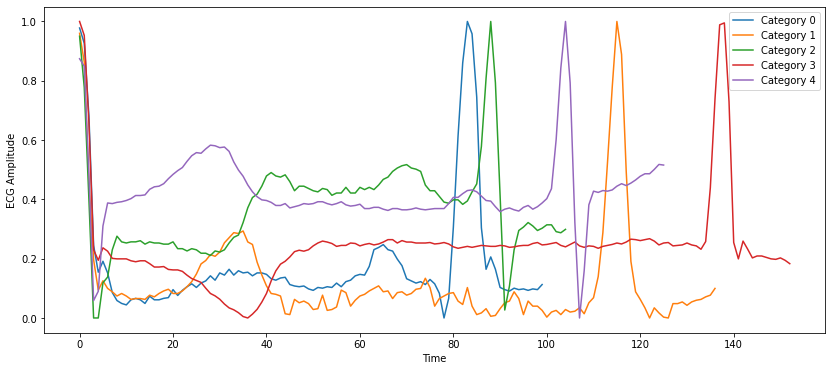

In [7]:
#stacked visualization 
plt.figure(figsize=(14, 6))
for i in range(5):
    idx_C = np.argwhere(np.array(y) == i)
    plt.plot(X[idx_C[0][0]], label=f'Category {i}')
    
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('ECG Amplitude')
plt.show()

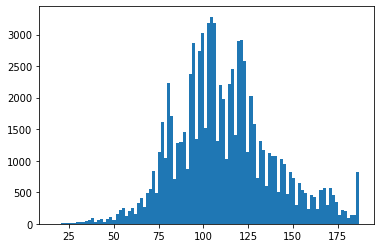

In [14]:
#histogram
plt.hist([len(_) for _ in X], bins=100)
plt.show()

Notice from the plots that there are some missing data in the randomly chosen sequences. They don't have the same length.  
For that we need some padding because we can't feed unharmonized data to our RNN model. 



In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_pad = pad_sequences(X, dtype='float32', padding='post', value=-1)
print(X_pad.shape)
print(X_pad[1])

(87554, 187)
[ 0.96011394  0.8632479   0.46153846  0.1965812   0.0940171   0.12535612
  0.0997151   0.08831909  0.07407407  0.08262108  0.07407407  0.06267806
  0.06552707  0.06552707  0.06267806  0.07692308  0.07122507  0.08262108
  0.09116809  0.09686609  0.08262108  0.08262108  0.09116809  0.10541311
  0.12250713  0.14814815  0.18233618  0.19373219  0.21367522  0.2079772
  0.22222222  0.25356126  0.27065527  0.2877493   0.28490028  0.2934473
  0.25641027  0.24786325  0.18803419  0.14529915  0.10826211  0.08262108
  0.07977208  0.07407407  0.01424501  0.01139601  0.06267806  0.05128205
  0.05698006  0.04843305  0.02849003  0.03133903  0.07692308  0.02564103
  0.02849003  0.03703704  0.0940171   0.08547009  0.03988604  0.05982906
  0.07407407  0.07977208  0.09116809  0.0997151   0.10826211  0.08831909
  0.09116809  0.06552707  0.08547009  0.08831909  0.07692308  0.08262108
  0.09686609  0.0997151   0.13390313  0.1025641   0.03988604  0.06552707
  0.07407407  0.08262108  0.08547009  0.

Wze are missing one dimension. The number of features per observation. 
We have to reshape X 

In [17]:
#reshaping X 
X_pad= np.expand_dims(X_pad, axis=-1)

In [18]:
#assertion 
assert(X_pad.shape == (87554, 187, 1))

In [25]:
#classes imbalance
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4]), array([72471,  2223,  5788,   641,  6431]))

notice the 5 classes are imbalanced with the first category to be the most common in our dataset. 


In [19]:
# to categorical 
y_cat = to_categorical(y)
y_cat.shap

(87554, 5)

In [28]:
#Splitting data 
X_train, X_test, y_train, y_test= train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [29]:
#baseline model 
sum_ = np.sum(y_train, axis=0)
predicted_category = np.argmax(sum_)

good_prediction = np.sum(y_test, axis=0)[predicted_category]
baseline_result = good_prediction/len(y_test)

print(f'Baseline accuracy: {baseline_result}')

Baseline accuracy: 0.8294215064816401


# Model 

Since we're dealing we ECG observations, we cannot ommit neither the beginning nor the end of the sequences as to their utter importance in the modelling. This is why we're going to use GRU or LSTM for their ability to avoid vanishing gradient

In [32]:
model = Sequential()
model.add(layers.Masking(mask_value=-1., input_shape=(187,1)))
model.add(layers.GRU(units=20, activation="tanh", input_shape=(187,1)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 187, 1)            0         
                                                                 
 gru (GRU)                   (None, 20)                1380      
                                                                 
 dense (Dense)               (None, 50)                1050      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2,685
Trainable params: 2,685
Non-trainable params: 0
_________________________________________________________________


In [35]:
es = EarlyStopping(patience=3, restore_best_weights=True)
#compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#fit model
model.fit(X_train, y_train,
          epochs=75,
          batch_size=128,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)
#evaluate model
model.evaluate(X_test, y_test)

Epoch 1/75
438/438 [==============================] - 61s 129ms/step - loss: 0.7415 - accuracy: 0.8248 - val_loss: 0.6522 - val_accuracy: 0.8301
Epoch 2/75
438/438 [==============================] - 56s 127ms/step - loss: 0.6791 - accuracy: 0.8266 - val_loss: 0.6473 - val_accuracy: 0.8301
Epoch 3/75
438/438 [==============================] - 55s 125ms/step - loss: 0.6744 - accuracy: 0.8266 - val_loss: 0.6472 - val_accuracy: 0.8301
Epoch 4/75
438/438 [==============================] - 55s 126ms/step - loss: 0.6721 - accuracy: 0.8266 - val_loss: 0.6476 - val_accuracy: 0.8301
Epoch 5/75
438/438 [==============================] - 55s 126ms/step - loss: 0.6708 - accuracy: 0.8266 - val_loss: 0.6482 - val_accuracy: 0.8301
Epoch 6/75
548/548 [==============================] - 11s 20ms/step - loss: 0.6530 - accuracy: 0.8294


[0.6529683470726013, 0.8294215202331543]

In [36]:
model = Sequential()
model.add(layers.Masking(mask_value=-1., input_shape=(187,1)))
model.add(layers.LSTM(units=20, activation="tanh", input_shape=(187,1)))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 187, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense_2 (Dense)             (None, 50)                1050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 3,065
Trainable params: 3,065
Non-trainable params: 0
_________________________________________________________________


In [37]:
es = EarlyStopping(patience=3, restore_best_weights=True)
#compile model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#fit model
model.fit(X_train, y_train,
          epochs=75,
          batch_size=128,
          verbose=1,
          callbacks = [es],
          validation_split=0.2)
#evaluate model
model.evaluate(X_test, y_test)

Epoch 1/75
438/438 [==============================] - 66s 135ms/step - loss: 0.7082 - accuracy: 0.8238 - val_loss: 0.6476 - val_accuracy: 0.8301
Epoch 2/75
438/438 [==============================] - 59s 135ms/step - loss: 0.6750 - accuracy: 0.8266 - val_loss: 0.6521 - val_accuracy: 0.8301
Epoch 3/75
438/438 [==============================] - 58s 132ms/step - loss: 0.6723 - accuracy: 0.8266 - val_loss: 0.6475 - val_accuracy: 0.8301
Epoch 4/75
438/438 [==============================] - 58s 131ms/step - loss: 0.6716 - accuracy: 0.8266 - val_loss: 0.6483 - val_accuracy: 0.8301
Epoch 5/75
438/438 [==============================] - 58s 131ms/step - loss: 0.6695 - accuracy: 0.8266 - val_loss: 0.6479 - val_accuracy: 0.8301
Epoch 6/75
548/548 [==============================] - 13s 23ms/step - loss: 0.6532 - accuracy: 0.8294


[0.6532407402992249, 0.8294215202331543]

this means that our model is as good as our baseline model that predicts the most present category. The reason is probably because the RNNs really return only the most present category.

In [38]:
#predict 
y_pred = model.predict(X_test)

In [39]:
#predicted classes
pd.DataFrame(y_pred).mean().sort_values()

3    0.006938
1    0.027807
2    0.062634
4    0.075729
0    0.826891
dtype: float32

In [40]:
#actual classes count 
pd.value_counts(y,normalize=True, ascending=True)

3    0.007321
1    0.025390
2    0.066108
4    0.073452
0    0.827729
dtype: float64

Our model is returning exactly the frequence of each labels in your training set!

We have 2 possibilities to counter the results: 
1. 
Try to balance the 5 classes in the training set.
2.  Another possibility is to do some data augmentation

To be continued 

